<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

Ссылка на github репозиторий: https://github.com/annalzrv/supervised_learning_practicum

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<a id='nav'></a>
**Цель исследования** - построить систему, способную спрогнозировать, уйдёт ли клиент из банка на основе данных о поведении клиентов и расторжении договора с банком.

**Ход исследования:**

Данные для исследования получим из файла `/datasets/Churn.csv`.

Проведём исследование в четыре этапа:

[1. Подготовка и обзор данных](#step1)<br>
[2. Подготовка признаков, исследование дисбаланса классов](#step2)<br>
[3. Борьба с дисбалансом, исследование ROC-кривых](#step3)<br>
[4. Проверка модели на тестовой выборке](#step4)<br>

## Подготовка данных
<a id='step1'></a>
[Вернуться к навигации](#nav)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Откроем файл и изучим данные.

In [2]:
data = pd.read_csv('Churn.csv')

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Заметим, что в каждом столбце по 10000 ненулевых строк, за ислючением `Tenure`. Рассмотрим эти пропусти поближе. 

In [5]:
pd.DataFrame(round(data.isna().mean()*100,).astype('int')).style.background_gradient('coolwarm')

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,9
Balance,0
NumOfProducts,0


В `Tenure` указано, сколько лет человек является клиентом банка. В столбце пропущено 9% значений. Возможно, это клиенты, которые с банком меньше года. Тогда в данных не должно быть данных о клиентах со значением `Tenure` = 0. Проверим эту гипотезу.

In [6]:
data[data['Tenure'] == 0]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
29,30,15656300,Lucciano,411,France,Male,29,0.0,59697.17,2,1,1,53483.21,0
35,36,15794171,Lombardo,475,France,Female,45,0.0,134264.04,1,1,0,27822.99,1
57,58,15647091,Endrizzi,725,Germany,Male,19,0.0,75888.20,1,0,0,45613.75,0
72,73,15812518,Palermo,657,Spain,Female,37,0.0,163607.18,1,0,1,44203.55,0
127,128,15782688,Piccio,625,Germany,Male,56,0.0,148507.24,1,1,0,46824.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9793,9794,15772363,Hilton,772,Germany,Female,42,0.0,101979.16,1,1,0,90928.48,0
9799,9800,15722731,Manna,653,France,Male,46,0.0,119556.10,1,1,0,78250.13,1
9843,9844,15778304,Fan,646,Germany,Male,24,0.0,92398.08,1,1,1,18897.29,0
9868,9869,15587640,Rowntree,718,France,Female,43,0.0,93143.39,1,1,0,167554.86,0


Гипотеза оказалась неверной. Значит, нельзя точно предположить, что является причиной появления пропусков. Удалим строки с пропущенными значениями в этом столбце. 

In [7]:
data = data[data['Tenure'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   float64
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


Проверим данные на наличие в них дубликатов.

In [8]:
data.duplicated().sum()

0

Явных дубликатов в данных нет, отлично. 

Перейдём к следущему этапу исследования данных и построим гистограммы для количественных переменных - столбцов `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `EstimatedSalary`.

/var/folders/xx/jwnnpwhn1flc8_y4wkgtzts80000gn/T/ipykernel_20352/3777518842.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'], ax=ax);


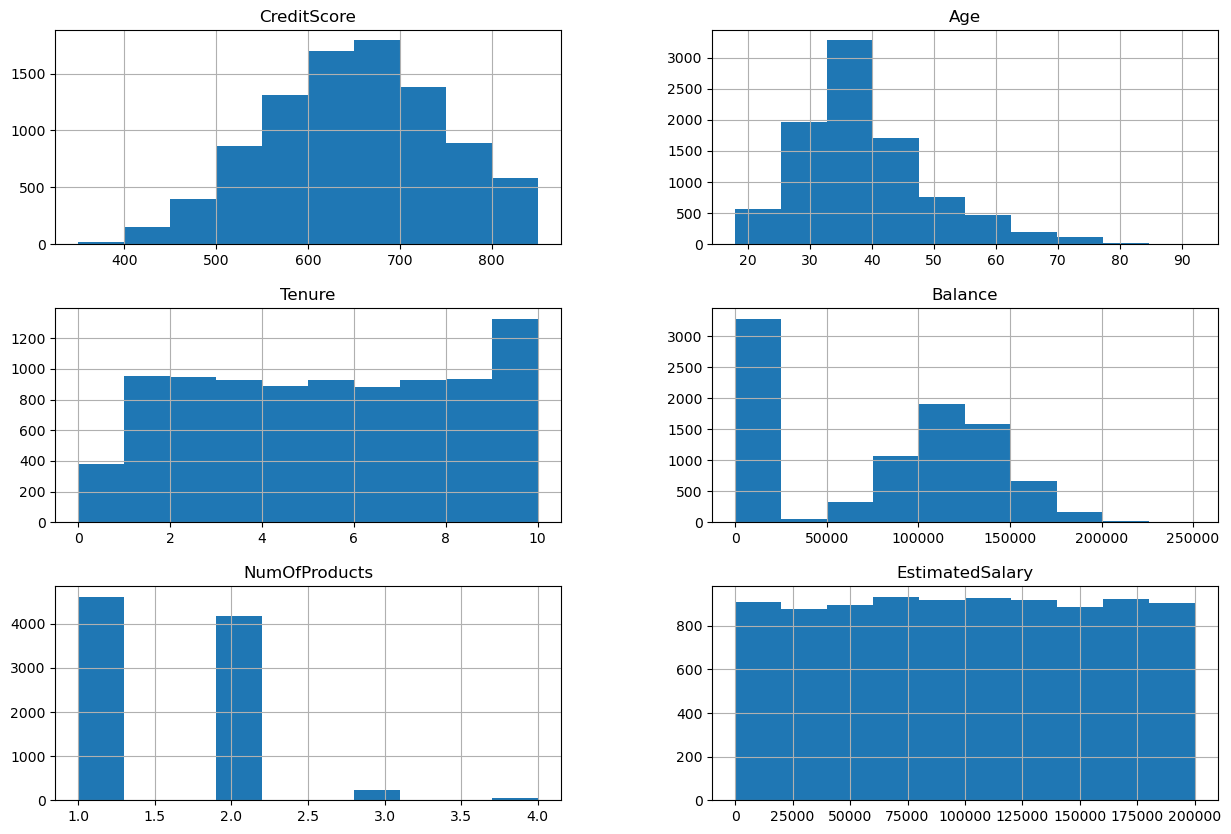

In [9]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
data.hist(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'], ax=ax);

Данные выглядят реалистично. 

По гистограмме столбца `Tenure` можно заметить, что у банка большего всего клиентов, пользующимися его услугами на протяжении 9-10 лет. 

У всех клиентов достаточно высокий `CreditScore`, значения столбца распределены нормально. 

По столбцу `Age` можно заметить, что большинство клиентов банка - люди возрастом от 30 до 40 лет. Но есть клиентв любых возрастов. 

Большинство клиентов пользуются 1-2 продуктами банка, а максимум продуктов, который можно иметь - 4. Это заметно по столбцу `NumOfProducts`.

Рассмотрим категориальные признаки - `Gender`, `HasCrCard`, `IsActiveMember`, `Exited` и `Geography`.

In [10]:
print('Gender:', data['Gender'].unique())
print('HasCrCard:', data['HasCrCard'].unique())
print('IsActiveMember:', data['IsActiveMember'].unique())
print('Exited:', data['Exited'].unique())
print('Geography:', data['Geography'].unique())

Gender: ['Female' 'Male']
HasCrCard: [1 0]
IsActiveMember: [1 0]
Exited: [1 0]
Geography: ['France' 'Spain' 'Germany']


Аномалий не обнаружено, идём дальше. Теперь нарисуем круговые диаграмы для некоторых категориальных признаков.

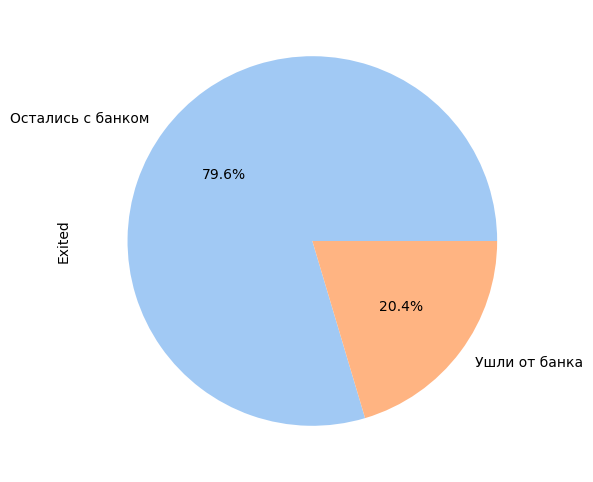

In [11]:
data['Exited'].value_counts().plot.pie(figsize=(6, 6), 
                                       labels=["Остались с банком", "Ушли от банка"], 
                                       colors = sns.color_palette('pastel')[0:2], 
                                       autopct='%1.1f%%');

Почти четверть клиентов отказалась от услуг банка. 

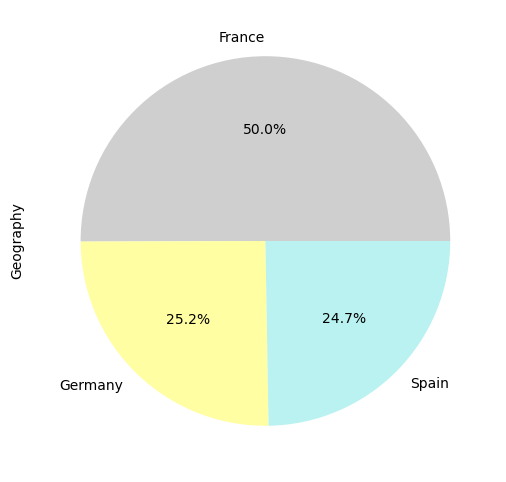

In [12]:
data['Geography'].value_counts().plot.pie(figsize=(6, 6),
                                       colors = sns.color_palette('pastel')[7:10], 
                                       autopct='%1.1f%%');

Клиентов из Германии - 50% от общего числа. Оставшаяся половина разделена поровну между клиентами из Германии и Испании. 

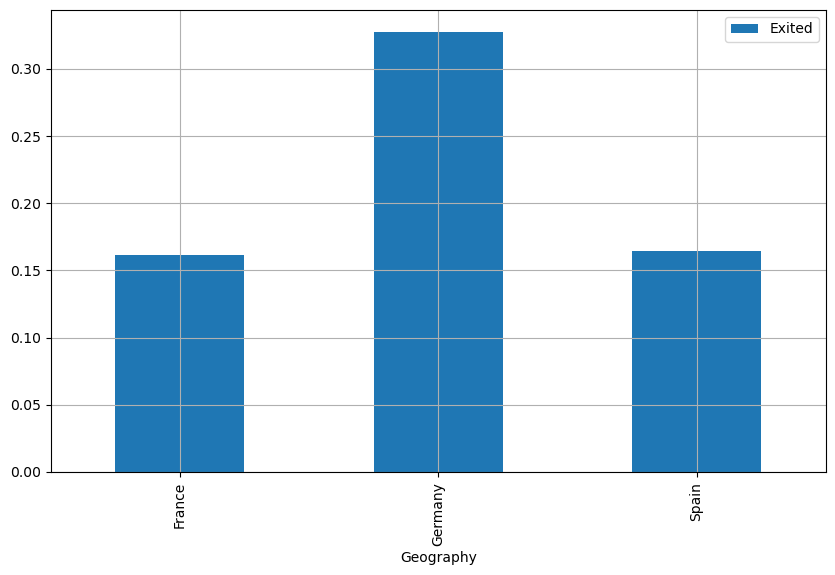

In [13]:
data.pivot_table(values='Exited', 
                 index='Geography', 
                 aggfunc='mean').plot(kind='bar', 
                                     figsize=(10,6), 
                                     grid=True);

Во Франции и Испании клиенты уход от банка с одинаковой частотой - примерно 17% уходят. А вот в Германии статистика в два раза выше - треть клиентов отказалась от услуг банка. 

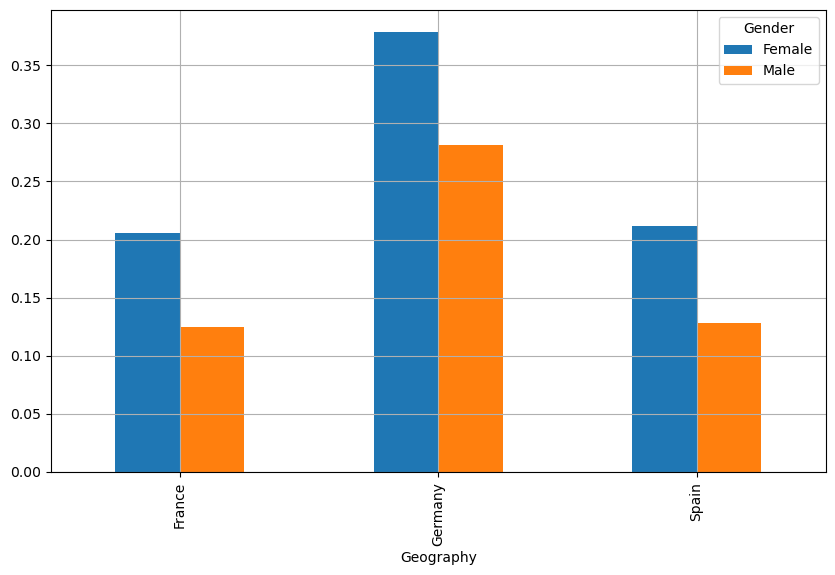

In [14]:
data.pivot_table(columns='Gender', 
                 index='Geography', 
                 values='Exited', 
                 aggfunc='mean').plot(kind='bar', 
                                      figsize=(10,6), 
                                      grid=True);

В каждой стране женщины значительно чаще уходят от банка, чем мужчины. 

Добавим в таблицу столбец `AgeGroup`, в который поместим округленное значение возраста. 

In [15]:
data['AgeGroup'] = (data['Age'] / 10).round().astype(int) * 10
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,40
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,40
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,40
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,40
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9995,15719294,Wood,800,France,Female,29,2.0,0.00,2,0,0,167773.55,0,30
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0,40
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0,40
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1,40


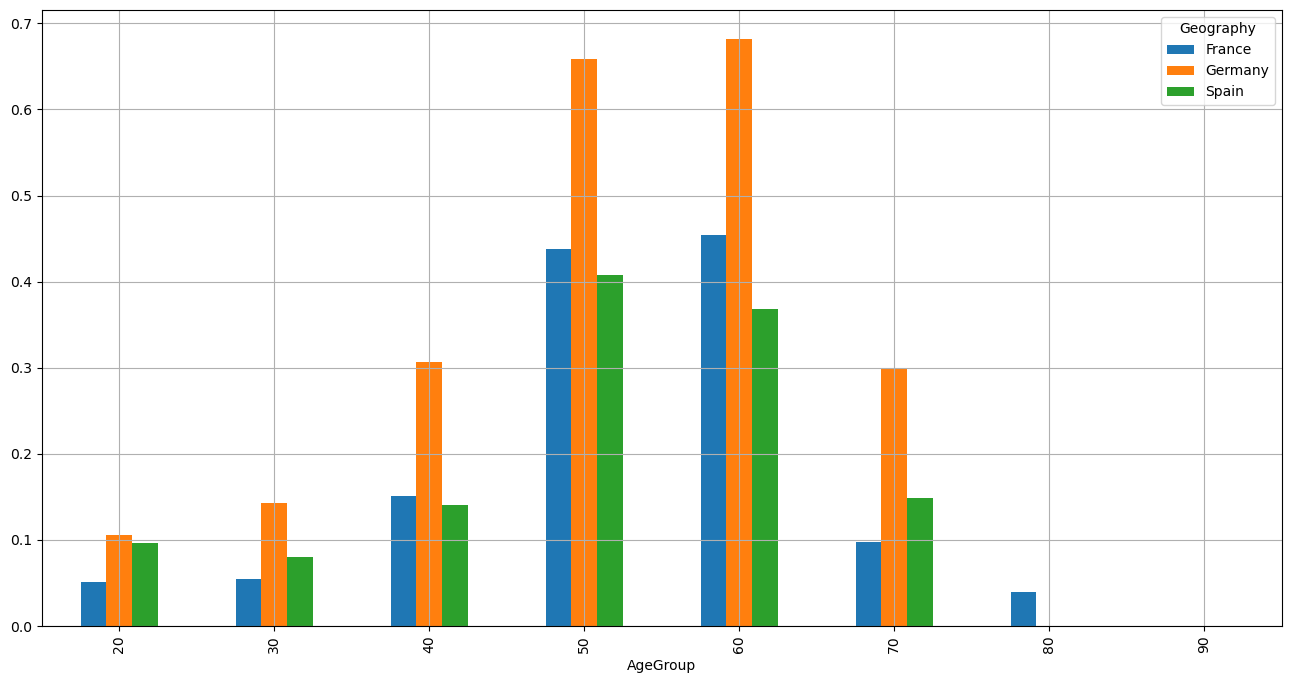

In [16]:
data.pivot_table(values='Exited', 
                 index='AgeGroup', 
                 columns='Geography', 
                 aggfunc='mean').plot(kind='bar', 
                                      figsize=(16,8), 
                                      grid=True);

В возрастной группе "20" клиентов из Испании почти столько же, сколько из Германии. В остальных категориях клиентов из Германии значительно боольше, чем из других двух стран. В возрастной группе "80" есть только клиенты из Франции. 

## Исследование задачи
<a id='step2'></a>
[Вернуться к навигации](#nav)

Уберём лишние признаки - `Surname`, `CustomerId`, `AgeGroup` и `RowNumber`.

In [17]:
data = data.drop(['Surname', 'CustomerId', 'RowNumber', 'AgeGroup'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Займёмся подготовкой признаков. 

Извлечём признаки для обучения в `features`, а целевой признак `Exited` сохраним в переменную `target`.
Выделим 20% данных для валидационной выборки, 20% для тестовой, остальные — для обучающей.

In [18]:
features = data.drop('Exited', axis=1)
target = data['Exited']

features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=.25, random_state=12345)

Преобразуем категориальные признаки в численные с помощью прямого кодирования One-Hot Encoding. Чтобы избежать дамми-ловушки, при вызове функции `pd.get_dummies()` укажем параметр `drop_first=True`.

In [19]:
categorical_cols = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

features_train = pd.get_dummies(features_train, columns=categorical_cols, drop_first=True)
features_valid = pd.get_dummies(features_valid, columns=categorical_cols, drop_first=True)
features_test = pd.get_dummies(features_test, columns=categorical_cols, drop_first=True)

In [20]:
features_train.shape

(5454, 13)

In [21]:
features_valid.shape

(1818, 13)

In [22]:
features_test.shape

(1819, 13)

Разделение отработало, как нужно. 60% - обучающая выборка, 20% - валидационная, 20% - тестовая.

В данных присутсивуют количественные признаки с разным разбросом значений. Чтобы алгоритм не решил, что признаки с большими значениями и разбросом значений важнее, займёмся масштабированием признаков. Воспользуемся методом стандартизации данных.

In [23]:
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [24]:
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Перейдём к обучению моделей. Сначала рассмотрим DecisionTreeClassifier. 

In [25]:
%%time

model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

print("F1 score на валидационной выборке: ", f1_score(target_valid, predictions_valid))
print()

F1 score на валидационной выборке:  0.47605633802816905

CPU times: user 19.6 ms, sys: 1.15 ms, total: 20.7 ms
Wall time: 20.2 ms


F1 score на валидационной выборке оказался достаточно низкий - 0.48. Сравним его с F1 score константной модели, которая всегда выдаёт 0 в качестве предсказания.  

In [26]:
target_pred_constant = pd.Series(0, index=target.index)

print("F1 score на валидационной выборке: ", f1_score(target_valid, predictions_valid))

F1 score на валидационной выборке:  0.47605633802816905


F1 score константной модели оказался равен F1 score модели на валидационной выборке. Значит, наша модель работает также, как константная. Скорее всего, мы столкнулись с дисбалансом классов. Посмотрим на то, как распределены классы в данных:

0    0.796062
1    0.203938
Name: Exited, dtype: float64


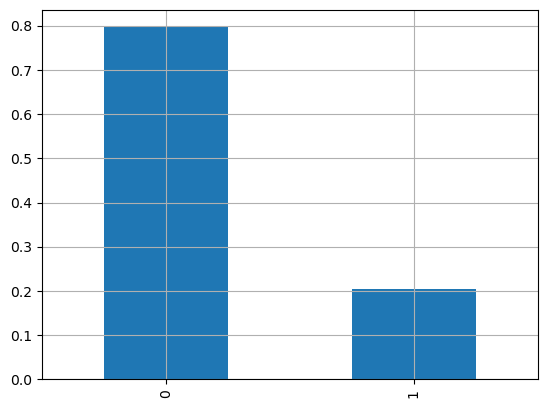

In [27]:
class_frequency = data['Exited'].value_counts(normalize=True)
print(class_frequency)

class_frequency.plot(kind='bar', grid=True);

Отрицательный класс представлен в выборке в 4 раза больше, чем положительный. Соотношение классов далеко от 1:1. Значит, мы наблюдаем дисбаланс классов, что плохо сказывается на обучении модели. 

## Борьба с дисбалансом
<a id='step3'></a>
[Вернуться к навигации](#nav)

Сначала обучим модель LogisticRegression на выборке с дисбалансом классов и зафиксируем значения F1-метрики на её предсказаниях. 

In [28]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predictions_valid))

F1: 0.4411764705882352


Теперь попробуем учесть дисбаланс классов с помощью параметра `class_weight='balanced'`.

In [29]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predictions_valid))

F1: 0.5484536082474227


Уже лучше. Теперь, чтобы избавиться от дисбаланса классов, воспользуемся техникой увеличения выборки - Upsampling. Напишем функцию `upsample`, которая будем увеличивать положительный класс в предложенное количество раз. 

In [30]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Применим фукнцию `upsample` для тренировочной выборки. Увеличим количество объектов положительного класса в 4 раза, чтобы сбалансировать выборку. 

In [31]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

Теперь обучим модель Логистической Регрессии на сбалансированной тренировочной выборке и зафиксируем её F1-меру на валидационной выборке. 

In [32]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train_upsampled, target_train_upsampled)
predictions_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predictions_valid))

F1: 0.5423037716615698


Теперь посмотрим на метрику `ROC-AUC Score`.

In [33]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC:', auc_roc)

ROC-AUC: 0.8286290626081982


Сравним ROC-кривую нашей модели с ROC-кривой случайной модели.

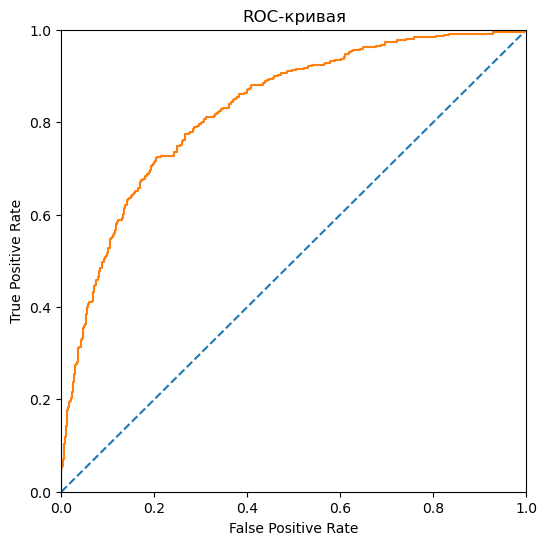

In [34]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure(figsize=(6, 6))

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

ROC-кривая нашей модели почти такая же, как ROC-кривая случайной модели. Попробуем увеличить `ROC-AUC Score` и поднять ROC-выше над ROC-кривой случайной модели.

Перейдём к модели Случайного Леса. Сначала обучим модель на выборке с дисбалансом классов и зафиксируем значения F1-метрики на её предсказаниях.

In [35]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predictions_valid))

F1: 0.5492227979274611


Теперь попробуем учесть дисбаланс классов с помощью параметра `class_weight='balanced'`.

In [36]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predictions_valid))

F1: 0.5396825396825398


Теперь обучим модель Случайного Леса на сбалансированной тренировочной выборке и зафиксируем её F1-меру на валидационной выборке. 

In [37]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train_upsampled, target_train_upsampled)
predictions_valid = model.predict(features_valid)

print('F1:', f1_score(target_valid, predictions_valid))

F1: 0.5880503144654088


F1 мера немного увеличилась по сравнению с несбалансированной выборкой. Теперь подберём гиперпараметры.

Переберём разные значения параметра максимальной глубины `max_depth` от 1 до 50 и `n_estimators` от 1 до 100, сравним метрики `f1_score` для каждого из них и найдём модель с самым высоким её значением.

In [38]:
%%time

best_f1_valid = 0
best_depth = 0
best_n_est = 0

for depth in range(1, 11):
    for n_est in range(1, 51):
        model = DecisionTreeClassifier(n_estimators=n_est, max_depth=depth, random_state=12345)
        model.fit(features_train_upsampled, target_train_upsampled)

        predictions_valid = model.predict(features_valid)
        f1_valid = f1_score(target_valid, predictions_valid)

        if f1_valid > best_f1_valid:
            best_f1_valid = f1_valid
            best_n_est = n_est
            best_depth = depth

print()
print('Validation F1:', best_f1_valid)
print('Best depth:', best_depth)
print('Best number of estimators:', best_n_est)
print()


Validation F1: 0.6092089728453365
Best depth: 10
Best number of estimators: 50

CPU times: user 42.5 s, sys: 192 ms, total: 42.7 s
Wall time: 42.7 s


Теперь возьмём лучшие результаты `n_estimators=36` и `max_depth=11` из исследования выше, обучим модель с таким набором гиперпараметров и посмотрим на её F1-меру.

In [41]:
%%time

model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=12345)
model.fit(features_train_upsampled, target_train_upsampled)
predictions_valid = model.predict(features_valid)

f1_valid = f1_score(target_valid, predictions_valid)

print()
print('Validation F1:', f1_valid)
print()


Validation F1: 0.6092089728453365

CPU times: user 265 ms, sys: 5.01 ms, total: 270 ms
Wall time: 268 ms


Получили достаточо высокие значения метрики F1. Посмотрим на ROC-кривую и `AUC-ROC score` полученной модели. 

AUC-ROC score: 0.8495687124599196


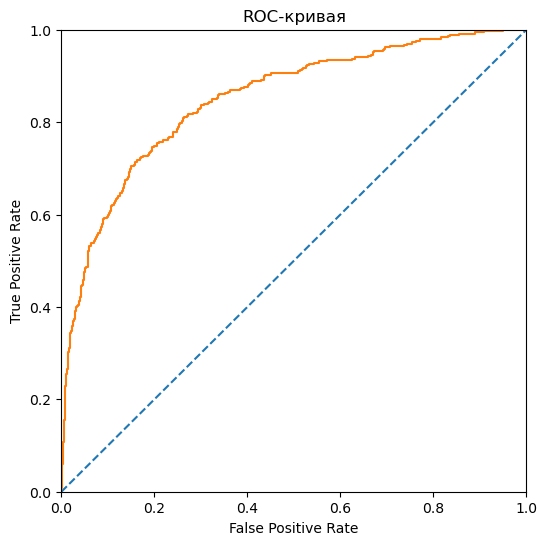

In [42]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC score:', auc_roc)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.figure(figsize=(6, 6))

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Теперь ROC-кривая стала выше кривой случайной модели и `AUC-ROC score` = 0.85. Можем перейти к проверке качества модели на тестовой выборке. 